In [1]:
import numpy as np
import cv2
#from skimage.feature import hog
#from scipy.misc import imresize
import matplotlib.pyplot as plt
from sklearn.externals import joblib
import matplotlib.image as mpimg
import pandas as pd
import glob
from sklearn.preprocessing import StandardScaler
#from skimage.io import imread
from xgboost.sklearn import XGBClassifier
from sklearn.neural_network import MLPClassifier
import sklearn.svm as svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
################################################################
import warnings
warnings.filterwarnings("ignore")
################################################################
%matplotlib inline

In [2]:
def extract_features(imgs, cspace='RGB', size = (64,64)):
    features = []
    for filename in imgs:
        image = cv2.imread(filename)
        image = cv2.resize(image, size)
        features.append(np.ravel(cv2.HOGDescriptor((64,64), (16,16), (8,8), (8,8), 9).compute(get_feature_space(image, cspace))))
    return features

In [3]:
def get_feature_space(img, cspace):
    if cspace != 'RGB':
        if cspace == 'HLS':
            features = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif cspace == 'YCrCb':
            features = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        elif cspace == 'HSV':
            features = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            features = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif cspace == 'YUV':
            features = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif cspace == 'Lab':
            features = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
        return features

def get_hog_features(img, cspace):
    return np.ravel(
        cv2.HOGDescriptor((64,64), (16,16), (8,8), (8,8), 9) \
            .compute(get_feature_space(img, cspace))
    )

In [4]:
#cv2.HOGDescriptor((64,64), (8,8), (8,8), (8,8), 9).compute(IMG).shape
vehicles = glob.glob('cars_brad/*.jpg')
non_vehicles = glob.glob('cars_brad_bg/*.jpg')
vehicle_features = extract_features(vehicles, cspace='YUV')
non_vehicle_features = extract_features(non_vehicles, cspace='YUV')

In [5]:
len(vehicle_features),len(vehicle_features[1]),len(non_vehicle_features),len(non_vehicle_features[0])

(1155, 1764, 1155, 1764)

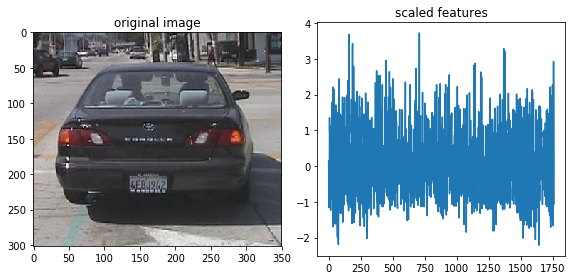

In [6]:
def plot_features(vehicle_features, non_vehicle_features):
    vehicle_features[0].shape
    if len(vehicle_features) > 0:
        X = np.vstack((vehicle_features, non_vehicle_features)).astype(np.float32)                        
        X_scaler = StandardScaler().fit(X)
        scaled_X = X_scaler.transform(X)
        vehicle_ind = np.random.randint(0, len(vehicles))
        fig = plt.figure(figsize=(12,4))
        plt.subplot(131)
        plt.imshow(mpimg.imread(vehicles[vehicle_ind]))
        plt.title('original image')
        plt.subplot(132)
        plt.plot(scaled_X[vehicle_ind])
        plt.title('scaled features')
        fig.tight_layout()
    return scaled_X, X_scaler
        
scaled_X, X_scaler = plot_features(vehicle_features, non_vehicle_features)

In [7]:
labels = np.hstack((np.ones(len(vehicle_features)), np.zeros(len(non_vehicle_features))))

X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, labels, test_size=0.2, random_state=4000)

In [8]:
svc = svm.SVC(probability=True)
svc.fit(X_train, y_train)
print('SVC results')
print('accuracy on training data: ', svc.score(X_train, y_train))
print('accuracy on test data: ', svc.score(X_test, y_test))
prediction = svc.predict(X_test[0].reshape(1, -1))

SVC results
accuracy on training data:  1.0
accuracy on test data:  1.0


In [9]:
xgb = XGBClassifier(colsample_bytree=0.2,learning_rate=0.05, max_depth=4, n_estimators=300)
cv_score = cross_val_score(xgb, X_train, y_train, cv = 5, n_jobs = -1)
xgb.fit(X_train,y_train)
print('Mean CV XGB: '+ str(np.mean(cv_score)))

Mean CV XGB: 0.9951307404965941


In [10]:
mlp = MLPClassifier(random_state=999)
mlp.fit(X_train, y_train)
print('MLP results')
print('accuracy on training data: ', mlp.score(X_train, y_train))
print('accuracy on test data: ', mlp.score(X_test, y_test))
prediction = mlp.predict(X_test[0].reshape(1, -1))

MLP results
accuracy on training data:  1.0
accuracy on test data:  1.0


In [11]:
joblib.dump(mlp, 'mlp1.pkl')
joblib.dump(X_scaler, 'scaler1.pkl')
mlp = joblib.load('mlp1.pkl')
X_scaler = joblib.load('scaler1.pkl')

In [12]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.75, 0.75)):
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    nx_windows = np.int(xspan/nx_pix_per_step) 
    ny_windows = np.int(yspan/ny_pix_per_step)
    window_list = []
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = (xs+1)*nx_pix_per_step + x_start_stop[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = (ys+1)*ny_pix_per_step + y_start_stop[0]
            window_list.append(((startx, starty), (endx, endy)))
    return window_list

In [13]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    draw_img = np.copy(img)
    for box in bboxes:
        cv2.rectangle(draw_img, box[0], box[1], color, thick)
    return draw_img

In [25]:
def annotate_img(path):
    image = cv2.imread(path)
    detected_vehicles = []
    pxs = 320
    INCREMENT_SIZE_BY = 16
    PXS_LIMIT = 720
    xy_overlap = (0.8, 0.8)
    
    while pxs < PXS_LIMIT:
        windows = slide_window(
            image, 
            x_start_stop = [None, None], 
            y_start_stop = [None, None], 
            xy_window = (pxs, pxs), 
            xy_overlap = xy_overlap
        )  
        for window in windows:
            features = []
            resized = cv2.resize((image[window[0][1]: window[1][1], window[0][0]: window[1][0]]),(64,64))
            hog_features = get_hog_features(resized,cspace='YUV')
            
            x_scaled = X_scaler.transform(hog_features.reshape(1,-1))
            
            if resized.shape[0] > 0:
                #print((xgb.predict_proba(x_scaled.reshape(1,-1))[0][1]),(mlp.predict_proba(x_scaled.reshape(1,-1))[0][1]),(svc.predict_proba(x_scaled.reshape(1,-1))[0][1]))
                if (((xgb.predict_proba(x_scaled.reshape(1,-1))[0][1]) > 0.99) or
                    ((mlp.predict_proba(x_scaled.reshape(1,-1))[0][1]) > 0.99) or
                    ((svc.predict_proba(x_scaled.reshape(1,-1))[0][1]) > 0.99)):
                    detected_vehicles.append(window)
        pxs += INCREMENT_SIZE_BY
        
    out = np.copy(image)
    boxes = draw_boxes(np.zeros_like(image), bboxes=detected_vehicles, thick=-1)
    _, contours, _ = cv2.findContours(boxes[:,:,2].astype('uint8'),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    
    for countour in contours:
        x, y, width, height = cv2.boundingRect(countour)
        cv2.rectangle(out, (x, y), (x + width, y + height), (0,255,0), 6)
        moments = cv2.moments(countour)
        cv2.circle(
            out, (
                int(moments['m10'] / moments['m00']), int(moments['m01'] / moments['m00'])
            ), 15, (255, 0, 0), -1
        )
    f, (ax1,ax2, ax3) = plt.subplots(1,3, figsize=(10,6))
    f.tight_layout()
    ax1.axis('off')
    ax1.set_title('original')
    ax1.imshow(image)
    ax2.axis('off')
    ax2.set_title('car detected box spots')
    ax2.imshow(boxes, cmap='hot')
    ax3.axis('off')
    ax3.set_title('Annotated car')
    ax3.imshow(out)
    
    return contours

In [26]:
def find_marker(cnts):
    
    c = max(cnts, key = cv2.contourArea)
    
    return cv2.minAreaRect(c)

In [27]:
def distance_to_camera(knownWidth, focalLength, perWidth):
    return (knownWidth * focalLength) / perWidth

In [28]:
# initialize the known distance from the camera to the object, which
# in this case is 24 inches
KNOWN_DISTANCE = 80

# initialize the known object width, which in this case, the piece of
# paper is 11 inches wide
KNOWN_WIDTH = 16

68.24ft
127.57ft
80.00ft
92.55ft
104.12ft
123.13ft


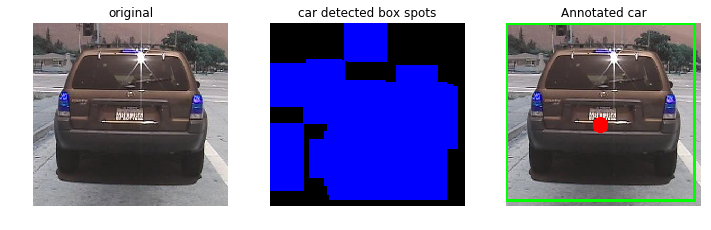

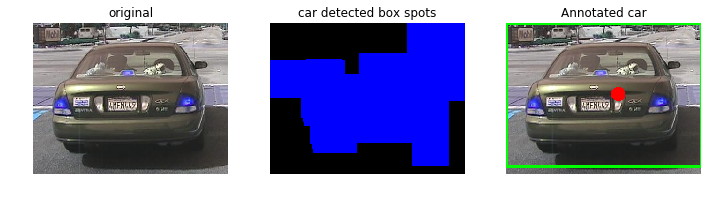

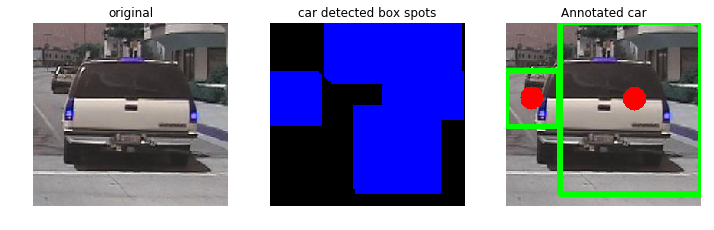

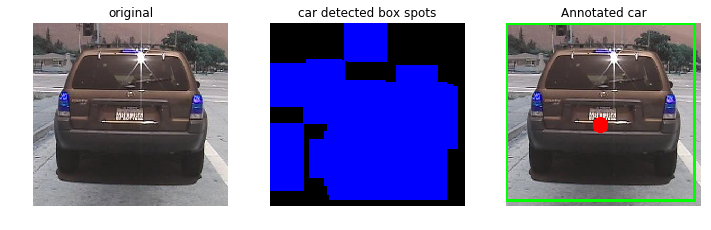

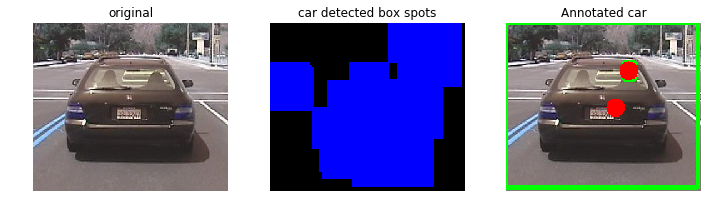

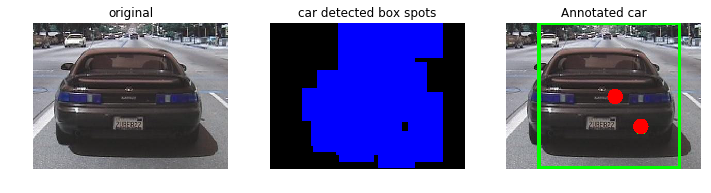

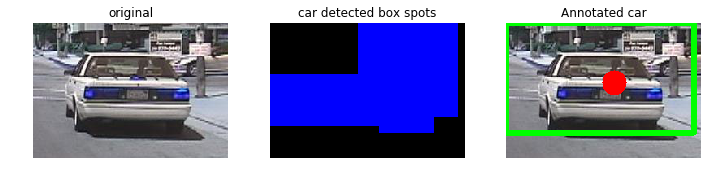

In [29]:
image = 'test_data/image_0051.jpg'
cnts = annotate_img(image)
marker = find_marker(cnts)
focalLength = (marker[1][0] * KNOWN_DISTANCE) / KNOWN_WIDTH

for image in glob.glob('test_data/*.jpg'):
    cnts = annotate_img(image)
    marker = find_marker(cnts)
    cm = distance_to_camera(KNOWN_WIDTH, focalLength, marker[1][0])
    print("%.2fft" % (cm))    